In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd 
from torch.utils.data import DataLoader
from dataset import MyDataset
from Alexnet import AudioAlexNet_digit
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import os
import argparse
from torch.nn import BCELoss






In [2]:
device = torch.device("cuda:0")

In [13]:
#speicify your targets here
root_dir = '../'
splits_path = 'preprocessed_data'
selected_num=0
samples = 1000
task="digit"
batch_size = 16

In [14]:
train_dataset = MyDataset(root_dir,splits_path, selected_num, "train",samples=samples,task=task)
test_dataset = MyDataset(root_dir,splits_path, selected_num, "test",samples=samples,task=task)

In [16]:
#Choose your model here
model = torch.load("../pre_trained_model/{}/best_acc.pth".format(task))

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)


In [18]:
imgs,targets = next(iter(test_loader))

In [19]:
imgs, targets = imgs.to(device),targets.to(device)

In [20]:
outputs = model(imgs)
outputs = outputs.max(1).indices.detach().cpu().numpy()

In [21]:
targets = targets.cpu().numpy()

In [22]:
comparison = pd.DataFrame()
print("Batch accuracy: ", (targets==outputs).sum()/len(targets))
comparison["labels"] = targets

comparison["outputs"] = outputs

Batch accuracy:  1.0


In [23]:
comparison

,labels,outputs
0,0,0
1,3,3
2,0,0
3,4,4
4,6,6
5,9,9
6,4,4
7,2,2
8,9,9
9,0,0


In [24]:
model._modules

OrderedDict([('features',
              Sequential(
                (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
                (1): ReLU(inplace=True)
                (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
                (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
                (4): ReLU(inplace=True)
                (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
                (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (7): ReLU(inplace=True)
                (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (9): ReLU(inplace=True)
                (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
                (11): ReLU(inplace=True)
                (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
          

In [25]:
def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer



In [26]:
def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 256, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,6)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,6,6))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers



In [27]:
def get_linear_layer_indices(model):
    offset = len(model._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model._modules['classifier']): 
        if isinstance(layer, nn.Linear): 
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices



In [28]:
def apply_lrp(model, image):
    image = torch.unsqueeze(image, 0)
    layers = list(model._modules['features']) \
                + dense_to_conv(list(model._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations
    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 14:
                activations[layer] = activations[layer].reshape((1, 1024, 1, 1))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0 
                        for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    relevances = [None] * n_layers + [activations[-1]]
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)
            
            # Apply variants of LRP depending on the depth
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9
            
            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data                                     
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward(); 
            c = activations[layer].grad       
            # Assign new relevance values           
            relevances[layer] = (activations[layer]*c).data                          
        else:
            relevances[layer] = relevances[layer+1]

    return relevances[0]


Groundtruth for this image:  2


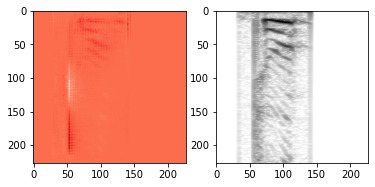

In [35]:
image_id =7
image_relevances = apply_lrp(model, imgs[image_id])
image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                image_relevances.max()), 
                                                (0, 1))
# Show relevances
pred_label = targets[image_id]
if outputs[image_id] == targets[image_id]:
    print("Groundtruth for this image: ", pred_label)

    # Plot images next to each other
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(image_relevances[:,:,0], cmap="Reds")
    plt.subplot(1,2,2)
    plt.imshow(imgs[image_id].permute(1,2,0).detach().cpu().numpy(),"Greys")
    plt.show()
else:
    print("This image is not classified correctly.")

# %%